In [1]:
# data prep
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD

# algorithmns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [68]:
# read in data

# through means of my own preparation, column names are saved in a txt file
with open('columns.txt','r') as cols:
    cols = cols.read().rstrip().split("\n")
    
# if necessary check cols with a print
# print(cols)

# read in train and test
train = pd.read_csv('census/census-income.data', na_values=['?',' ',' ?',' ?',' ? ',''], names=cols)
test = pd.read_csv('census/census-income.test', na_values=['?',' ',' ?',' ?',' ? ',''], names=cols)

# check shapes
for ds in [train, test]:
    print("Rows: {} Columns: {}".format(*ds.shape))

Rows: 199523 Columns: 42
Rows: 99762 Columns: 42


In [69]:
# fix target in training set
train.target = train.target.apply(lambda x: int(x.replace(".","").strip("+").replace(" ","")))
# looks good: type int and (-) are represented
train.target.sample(5)

126588   -50000
39777    -50000
163470   -50000
50690    -50000
21130    -50000
Name: target, dtype: int64

In [70]:
# check the proportionals of the target variable
vc = pd.DataFrame(train.target.value_counts())
vc['%'] = np.round((vc['target'] / len(train) * 100), 2)
vc.loc['total'] = vc.sum()
# highly imbalanced dataset
vc

,target,%
-50000,187141.0,93.79
50000,12382.0,6.21
total,199523.0,100.00


In [71]:
# descriptive features that I think are important
def aboutData(df):
    t = pd.DataFrame(df.isnull().sum(), columns=['#NA'])
    t['#Count'] = len(df) - t['#NA']
    t['#Distinct'] = df.nunique()
    # explanation of the #notinuniverse count later in EDA
    t['#NotInUniverse'] = df.apply(lambda x: np.sum(x == ' Not in universe'), axis=0)
    t['dtype'] = df.dtypes
    t['skew'] = df.skew()
    return t

# ignore - pd.concat if you'd like to put the entire dataset through the func and
# sanity checking myself
# pd.concat([train,test], ignore_index=True)
# for col in cols:
#     if train[col].dtype == 'object':
#         nius = len(train[train[col] == ' Not in universe'])
#         print("Column: {} \tNumber of NIU: {}".format(col, nius))

info = aboutData(train)
info

,#NA,#Count,#Distinct,#NotInUniverse,dtype,skew
age,0,199523,91,0,int64,0.373290
class of worker,0,199523,9,100245,object,NaN
detailed industry recode,0,199523,52,0,int64,0.516688
detailed occupation recode,0,199523,47,0,int64,0.829238
education,0,199523,17,0,object,NaN
wage per hour,0,199523,1240,0,int64,8.935097
enroll in edu inst last wk,0,199523,3,186943,object,NaN
marital stat,0,199523,7,0,object,NaN
major industry code,0,199523,24,0,object,NaN
major occupation code,0,199523,15,100684,object,NaN


In [72]:
# missing values and information
info.loc[info['#NA'] > 0]
# - high disproportions of 'Not in universe' values: most likely drop
# - half of migration code variables are missing: most likely drop
# - some NAs in the country of birth columns: impute/feature engineer

,#NA,#Count,#Distinct,#NotInUniverse,dtype,skew
state of previous residence,708,198815,50,183750,object,NaN
migration code-change in msa,99696,99827,9,1516,object,NaN
migration code-change in reg,99696,99827,8,1516,object,NaN
migration code-move within reg,99696,99827,9,1516,object,NaN
migration prev res in sunbelt,99696,99827,3,84054,object,NaN
country of birth father,6713,192810,42,0,object,NaN
country of birth mother,6119,193404,42,0,object,NaN
country of birth self,3393,196130,42,0,object,NaN


In [73]:
# Going to drop cols with too many 'not in universe' values
drops = info[info['#NotInUniverse'] > 80000].index.tolist()
drops
# Pause work on missing values for now
# Proceed with EDA

['class of worker',
 'enroll in edu inst last wk',
 'major occupation code',
 'member of a labor union',
 'reason for unemployment',
 'region of previous residence',
 'state of previous residence',
 'migration prev res in sunbelt',
 'family members under 18',
 "fill inc questionnaire for veteran's admin"]

In [74]:
# EDA
# columns into groups by types

# special cases that are int/float in the dataset, but should be treated as categorical
spcase = train.columns[train.columns.str.contains('recode')].tolist()
spcase.extend(['year','own business or self employed','veterans benefits'])

# extract dtypes from columns
nomial = train.select_dtypes(include=['object']).columns.tolist()
nomial.extend(spcase)
continuous = train.select_dtypes(include=['int','float']).columns.tolist()
continuous = [x for x in continuous if x not in spcase]

print("nomials ({}) : {}\n".format(len(nomial), nomial))
print("continuous ({}) : {}\n".format(len(continuous), continuous))

nomials (33) : ['class of worker', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', "fill inc questionnaire for veteran's admin", 'detailed industry recode', 'detailed occupation recode', 'year', 'own business or self employed', 'veterans benefits']

continuous (9) : ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'instance weight'

In [75]:
# nomial countplots

# plt.figure(figsize=(25,55));

# for i,col in enumerate(nomial):
#     plt.subplot(11,3,i+1);
#     sns.countplot(y=col, data=train);

# see a lot of not in universe affecting variables, so at this point the aboutData function was modified

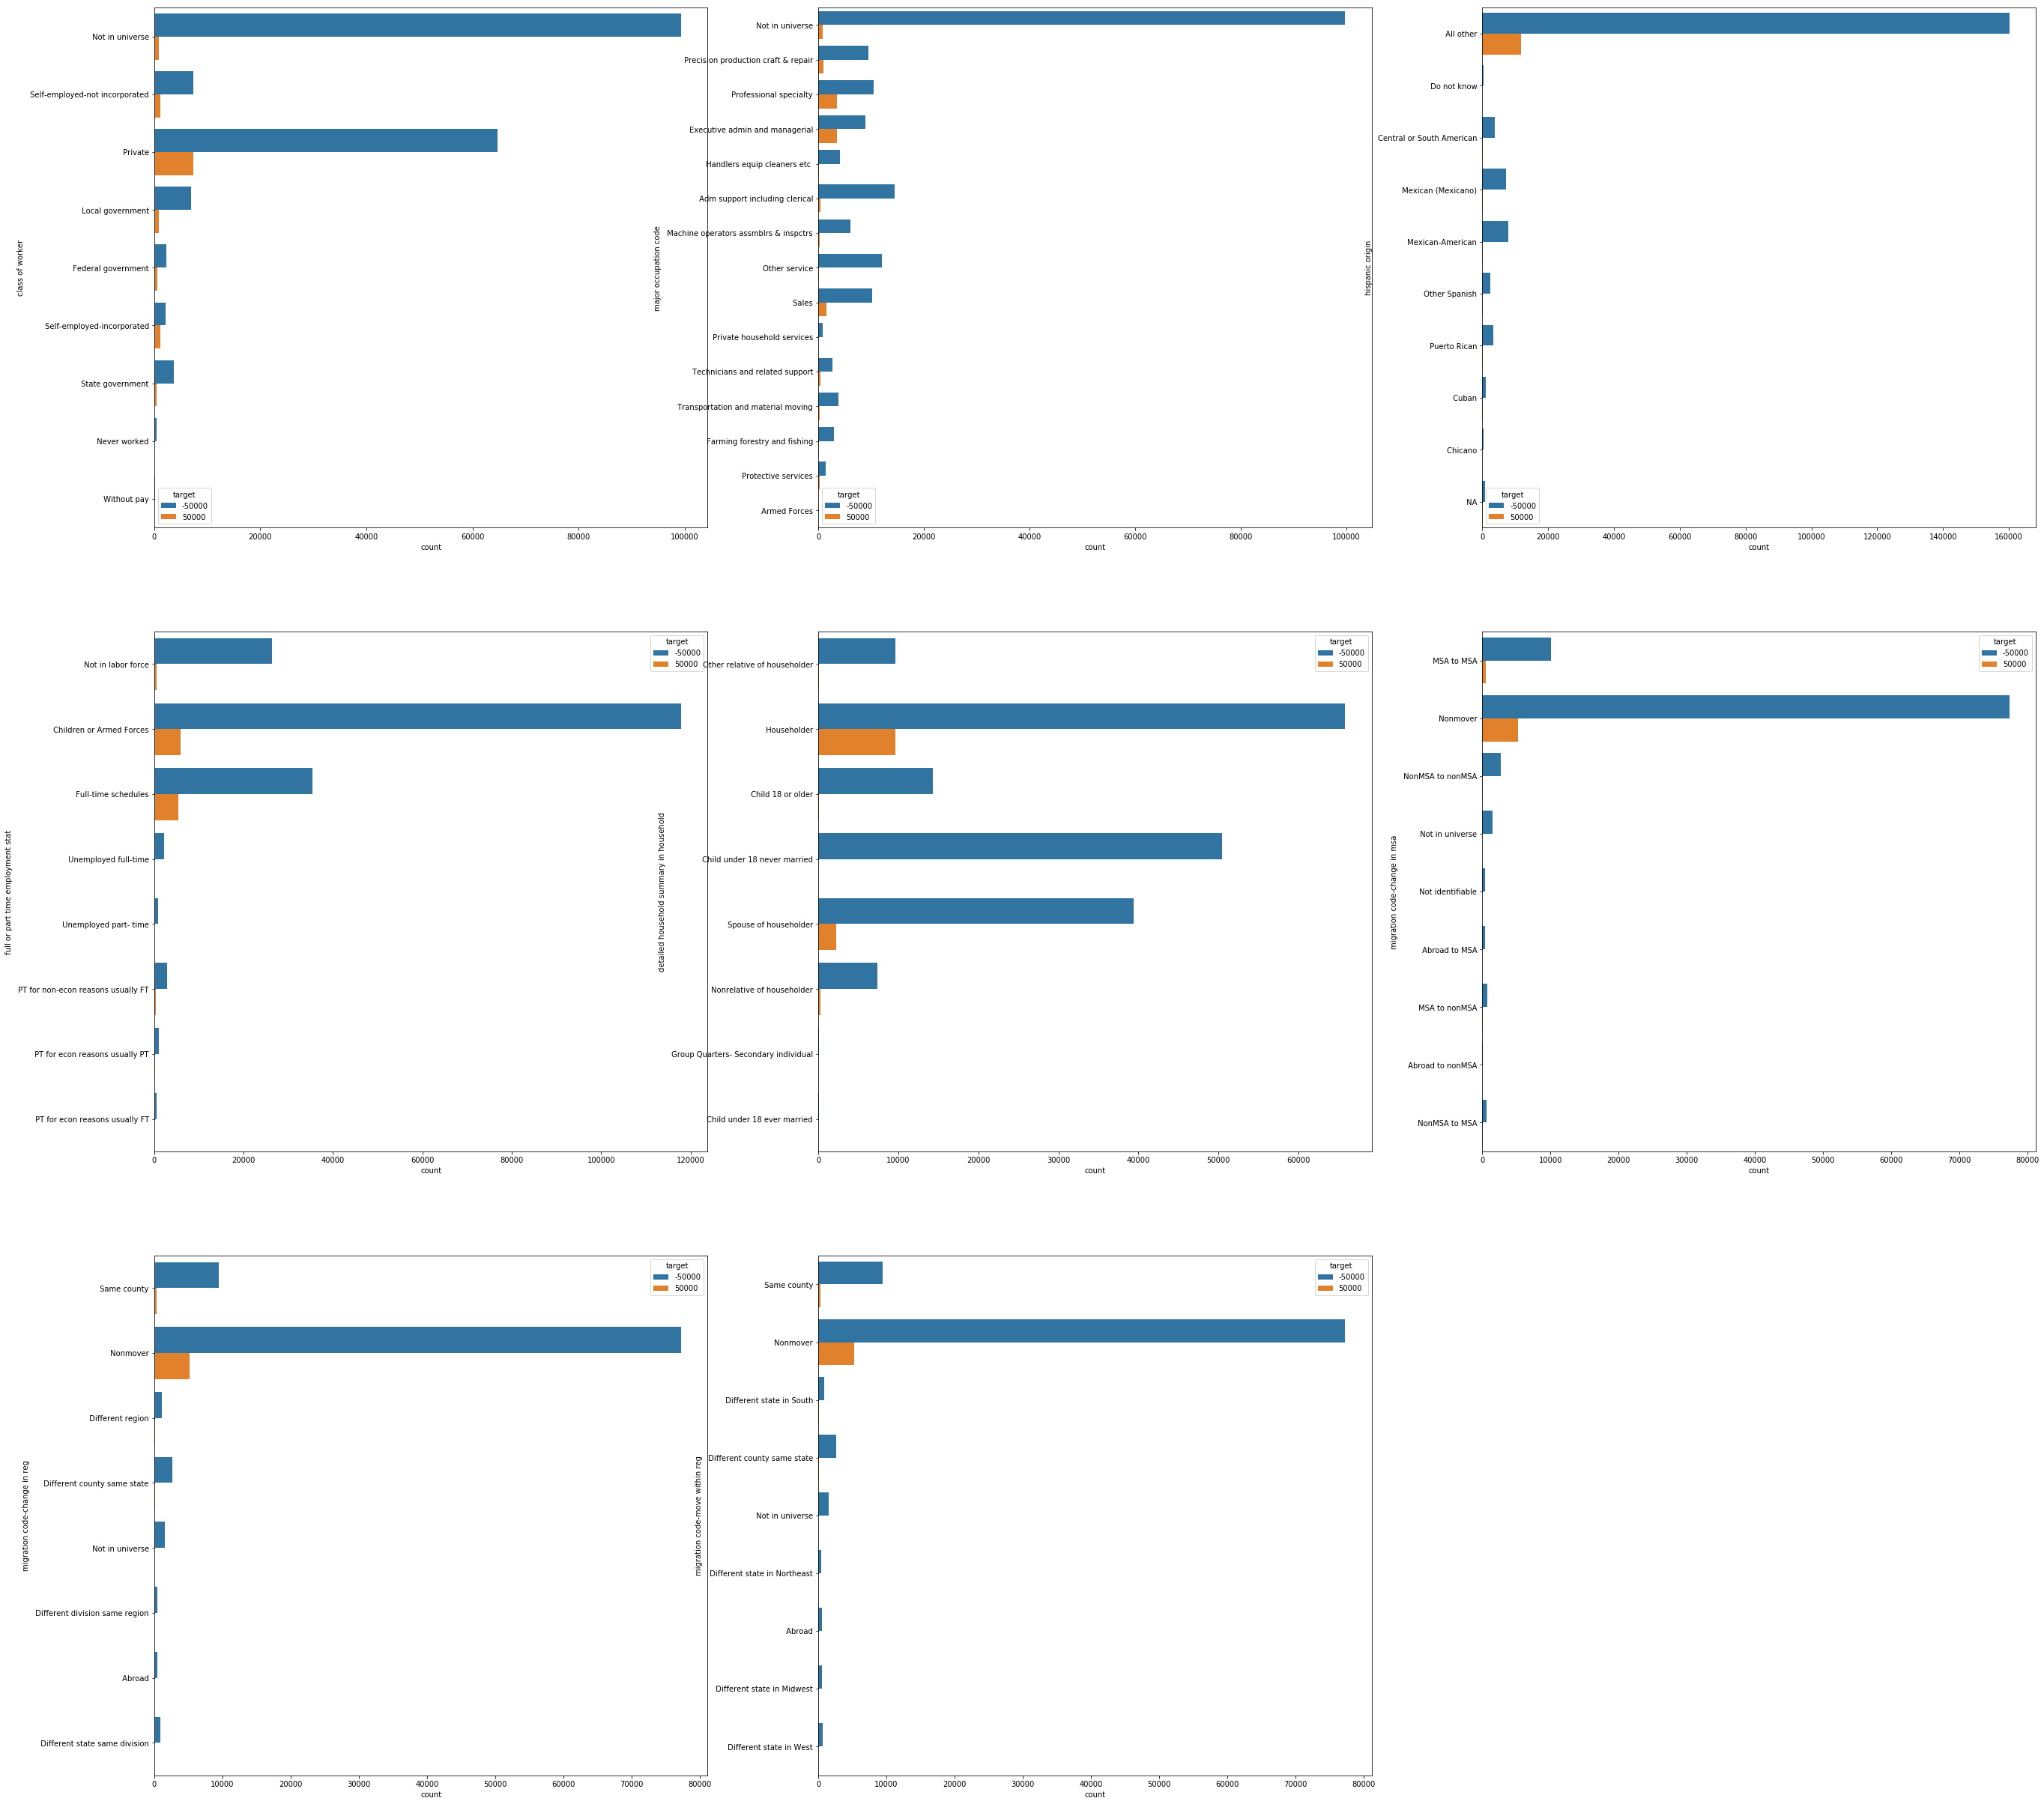

In [76]:
# medium

plt.figure(figsize=(45,120));
md_nomials = []
for col in nomial:
    if (info.loc[col,'#Distinct'] >= 8) and (info.loc[col,'#Distinct'] <=15):
        md_nomials.append(col)

for i,col in enumerate(md_nomials):
    plt.subplot(len(md_nomials),3,i+1);
    sns.countplot(y=col, data=train, hue='target');
#     plt.xticks(rotation=25);

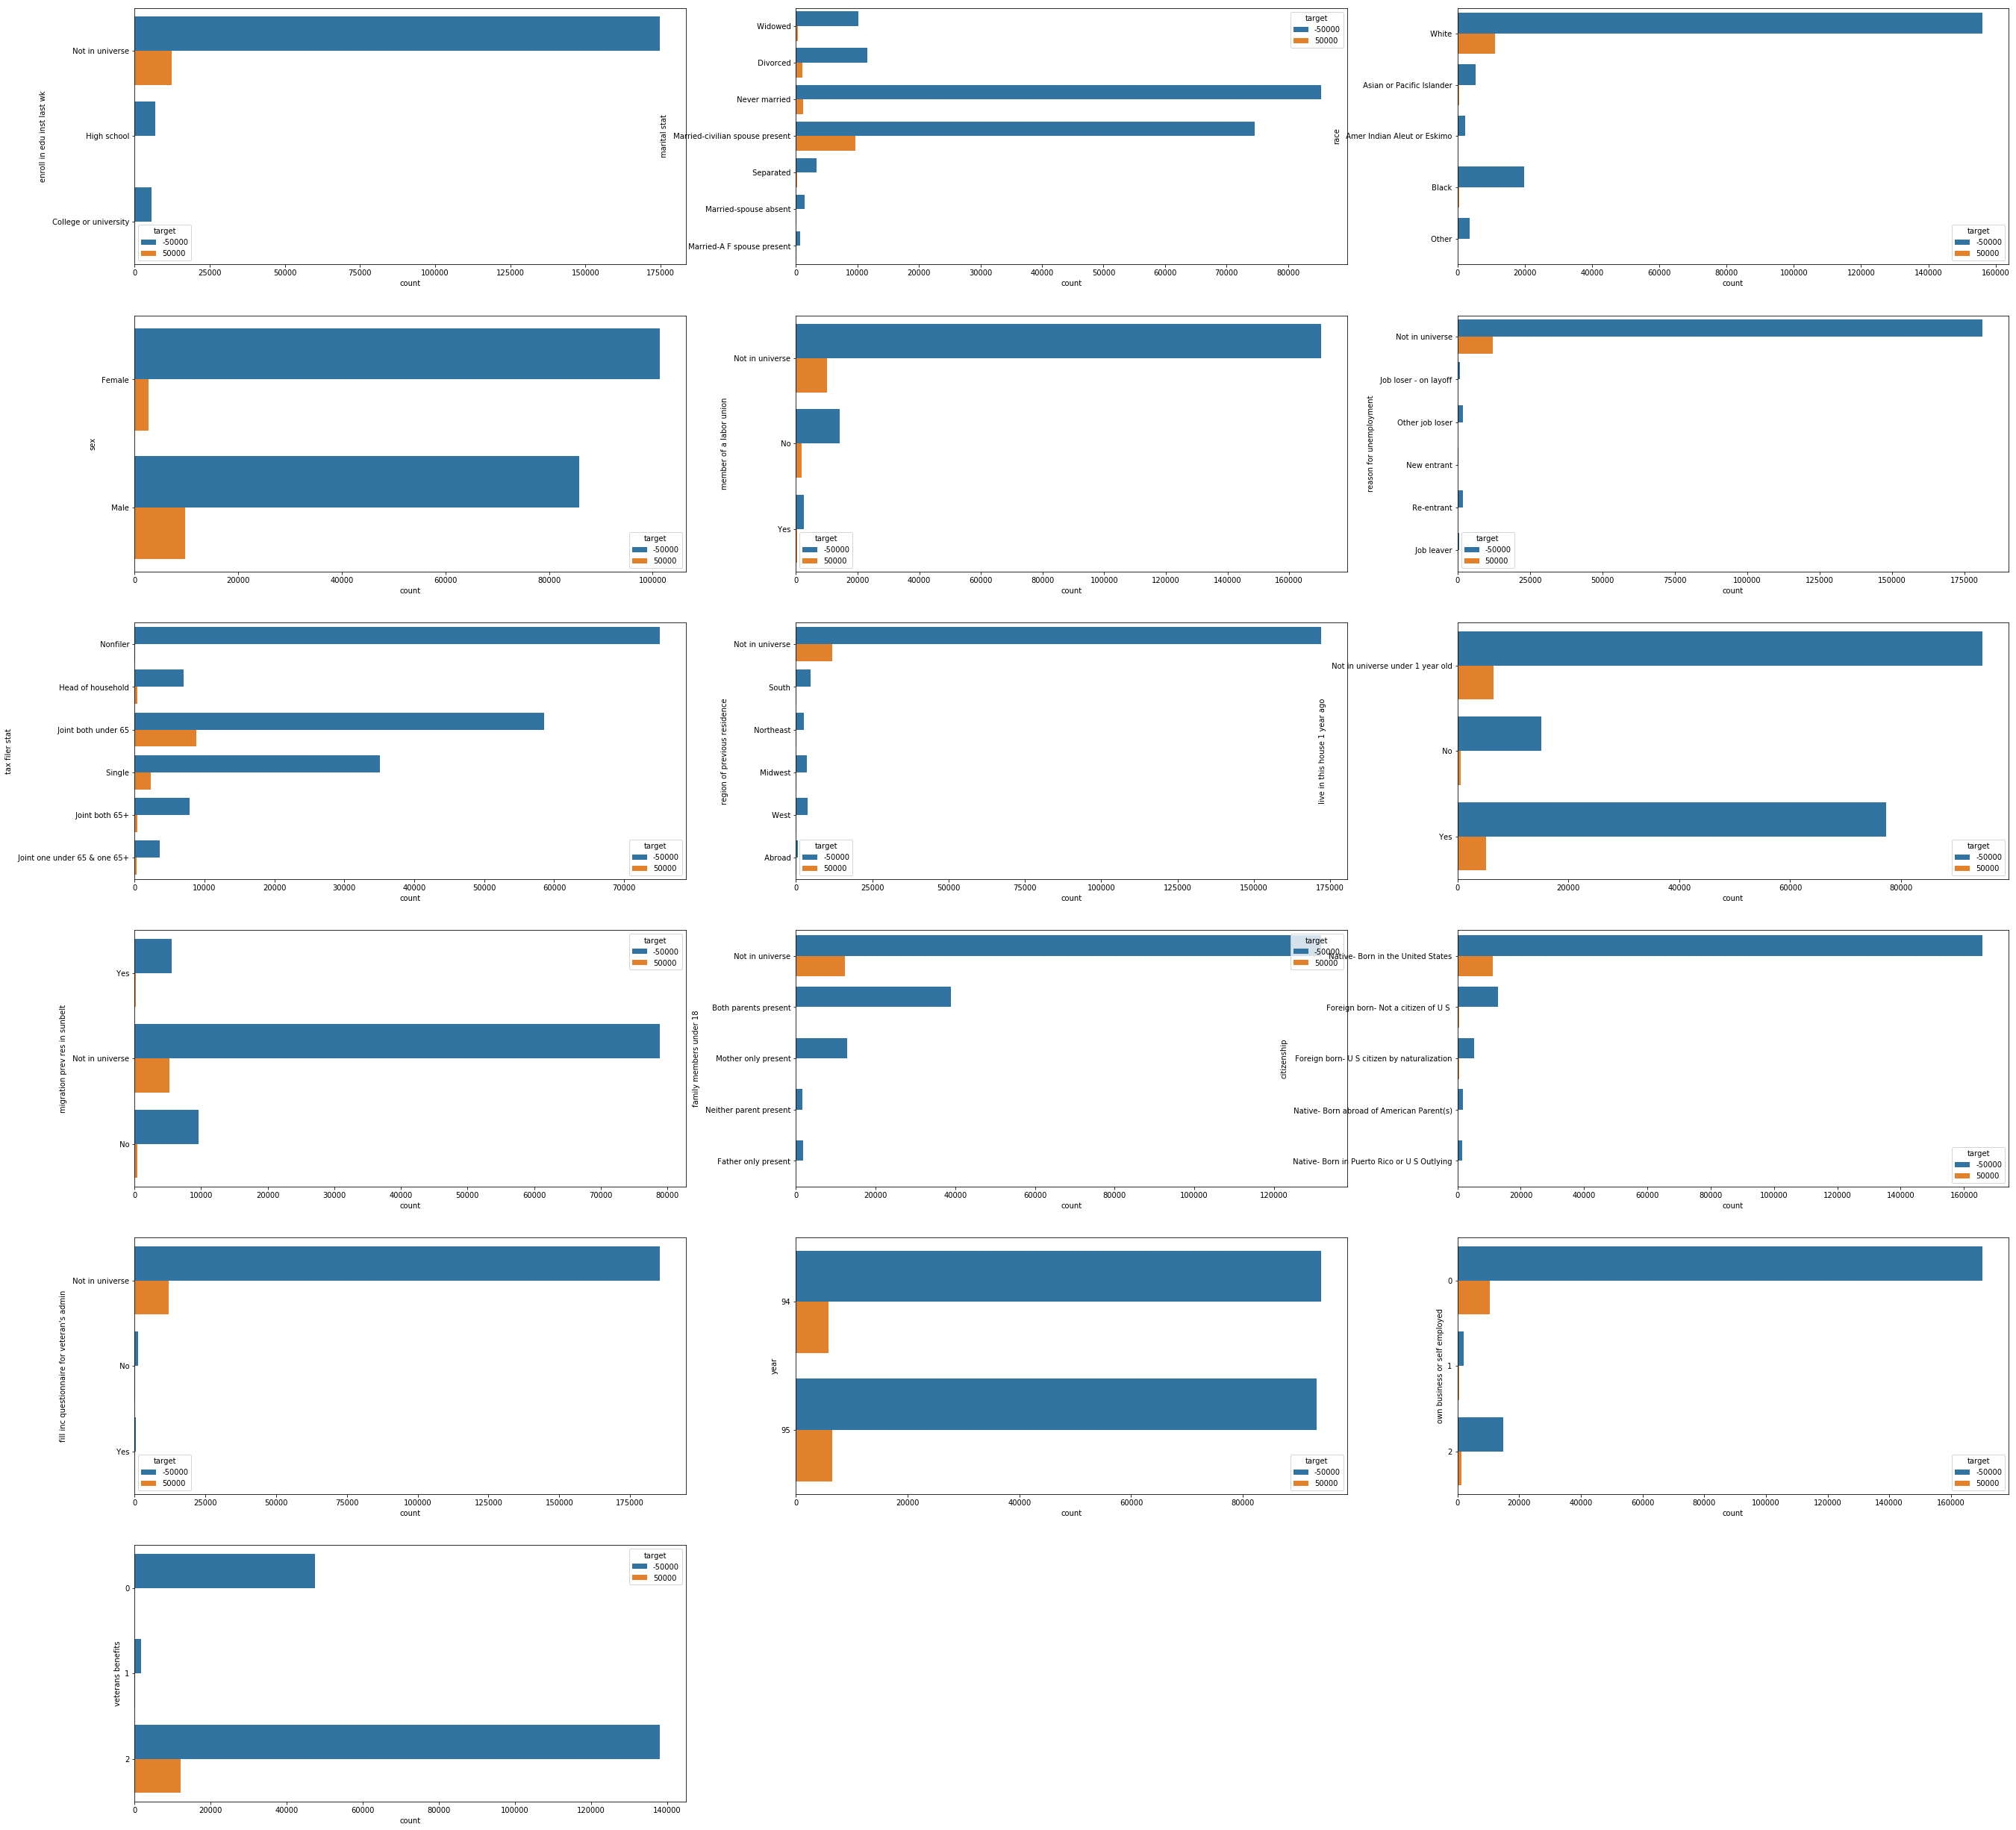

In [77]:
# target compared with some nomial

plt.figure(figsize=(45,120));
sm_nomials = []
for col in nomial:
    if info.loc[col,'#Distinct'] < 8:
        sm_nomials.append(col)

for i,col in enumerate(sm_nomials):
    plt.subplot(len(sm_nomials),3,i+1);
    sns.countplot(y=col, data=train, hue='target');
#     plt.xticks(rotation=25);
    
# year doesn't add anything to the model - can be dropped
# male and married = indicators of +50k
# tax filer stat = good indicator

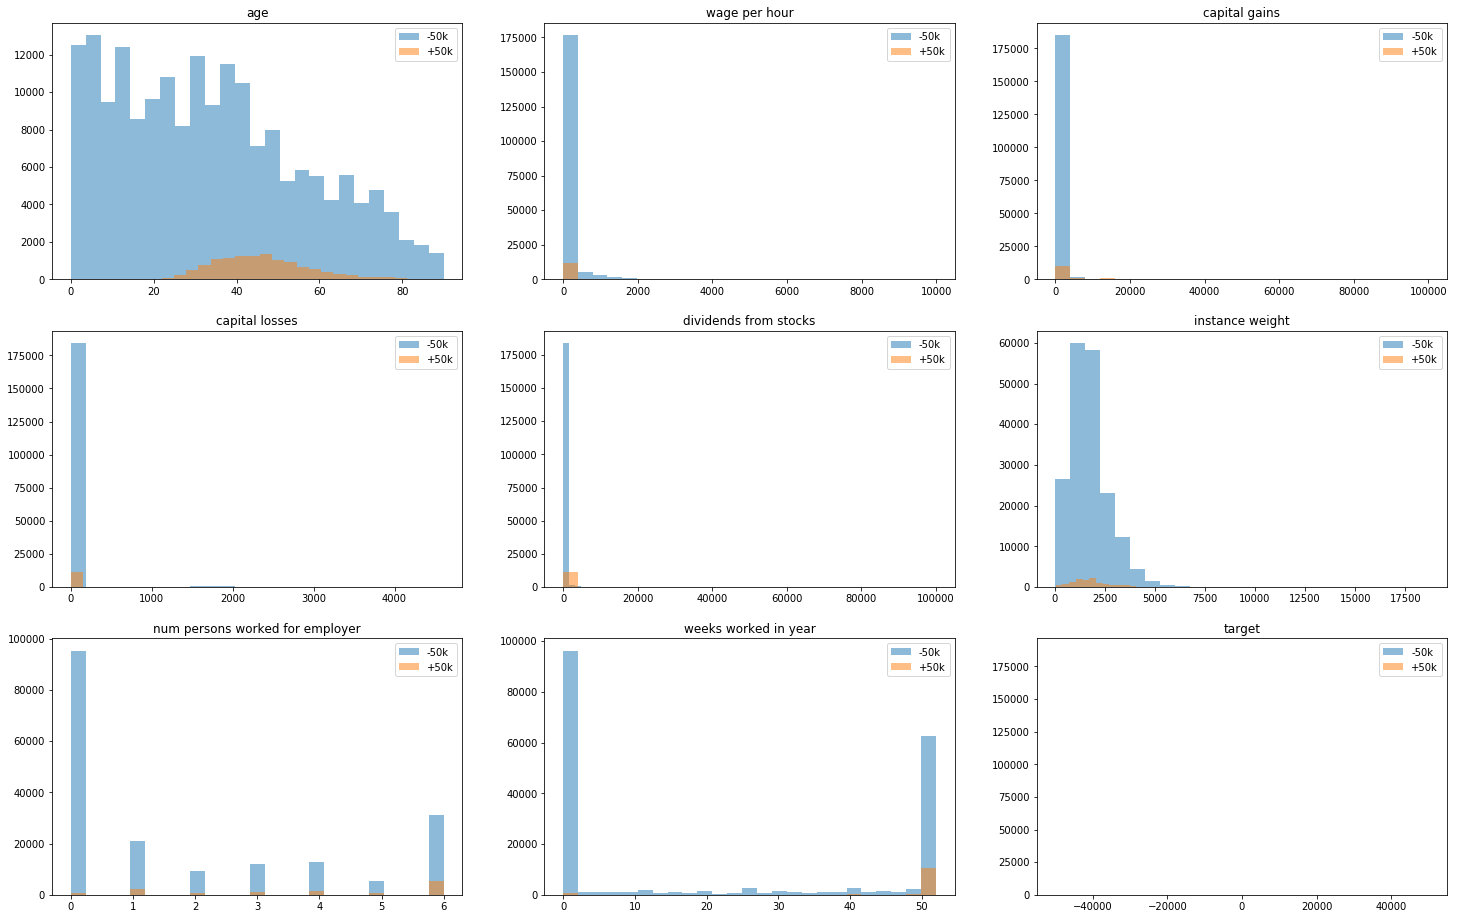

In [78]:
# continous hists and stripplots
plt.figure(figsize=(25,50))
for i,col in enumerate(continuous):
    plt.subplot(len(continuous),3,i+1);
    above = train.loc[train['target'] == 50000,col]
    below = train.loc[train['target'] == -50000,col]
    plt.hist(below, bins=25, alpha=0.5);
    plt.hist(above, bins=25, alpha=0.5);
    plt.title(col);
    plt.legend(['-50k','+50k']);

In [79]:
# interestingly enough 'age' contains zeroes
print(train.loc[train.age == 0].shape)
# ... and there are almost 3000 instances! is this a mistake?

# Minors included? Are any making 50k a year?
for n in np.arange(19):
    nAge = np.sum(train.age == n)
    nAge50k = np.sum(((train.age == n) & (train.target == 50000)))
    n
    print("{:5} individual(s) of age {:5} and {:5} make(s) +50k".format(nAge, n, nAge50k))
# dang!

(2839, 42)
 2839 individual(s) of age     0 and     0 make(s) +50k
 3138 individual(s) of age     1 and     0 make(s) +50k
 3236 individual(s) of age     2 and     0 make(s) +50k
 3279 individual(s) of age     3 and     0 make(s) +50k
 3318 individual(s) of age     4 and     0 make(s) +50k
 3332 individual(s) of age     5 and     0 make(s) +50k
 3171 individual(s) of age     6 and     0 make(s) +50k
 3218 individual(s) of age     7 and     0 make(s) +50k
 3187 individual(s) of age     8 and     0 make(s) +50k
 3162 individual(s) of age     9 and     0 make(s) +50k
 3134 individual(s) of age    10 and     0 make(s) +50k
 3128 individual(s) of age    11 and     0 make(s) +50k
 3060 individual(s) of age    12 and     0 make(s) +50k
 3152 individual(s) of age    13 and     0 make(s) +50k
 3068 individual(s) of age    14 and     0 make(s) +50k
 2926 individual(s) of age    15 and     0 make(s) +50k
 2882 individual(s) of age    16 and     1 make(s) +50k
 2762 individual(s) of age    17 and 

In [80]:
# it's a valid assumption that individuals under 16
# are not making +50k a year or there is a large percent of these individuals in the working class
# to be removed...
minors = []
for n in np.arange(16):
    indices = train.loc[train.age == n,'age'].index.tolist()
    minors.extend(indices)
len(minors)

50348

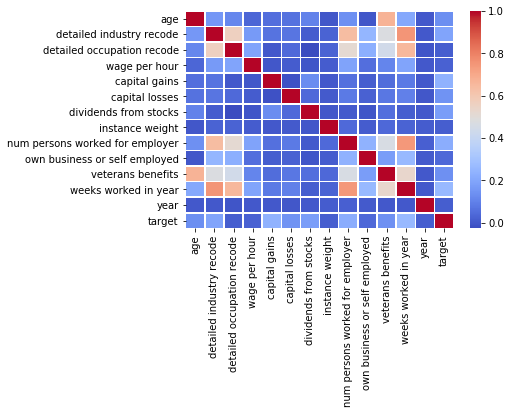

In [81]:
sns.heatmap(train.corr(), linewidths=0.5, cmap='coolwarm');

In [82]:
# Combine all our dropped features into a list
code_migs = train.columns[train.columns.str.contains('code-')].tolist()
drops.extend(code_migs)
drops.append('year')
# modify df's
train = train.drop(drops, axis=1)
# remove minors from training
train = train.drop(minors)
test = test.drop(drops, axis=1)

In [83]:
aboutData(train)

,#NA,#Count,#Distinct,#NotInUniverse,dtype,skew
age,0,149175,75,0,int64,0.507984
detailed industry recode,0,149175,52,0,int64,0.011987
detailed occupation recode,0,149175,47,0,int64,0.384482
education,0,149175,16,0,object,NaN
wage per hour,0,149175,1240,0,int64,7.717631
marital stat,0,149175,7,0,object,NaN
major industry code,0,149175,24,0,object,NaN
race,0,149175,5,0,object,NaN
hispanic origin,0,149175,10,0,object,NaN
sex,0,149175,2,0,object,NaN


In [84]:
# Hypotheses so far:

# Important features are ...
# - tax filer (eng)
# - weeks worked
# - wage per hour
# - has dividends from stocks (eng)
# - citizenship
# - capital gains/losses
# - education
# - age bin (eng)
# - married
# - race
# - sex
# - [major industry code] 
# - employment stat
# - veterans benefits

# clean up the last variables with NAs
for col in ['country of birth self','country of birth mother','country of birth father']:
    train[col] = train[col].fillna('Unk')
    test[col] = test[col].fillna('Unk')

# Feature Engineering

# age bins
buckets = np.linspace(0, 100, 15)
labels = np.arange(14).tolist()
train['ageBinned'] = pd.cut(train.age, bins=buckets, labels=labels)
test['ageBinned'] = pd.cut(test.age, bins=buckets, labels=labels)

# tax filer
train['is_taxfiler'] = train['tax filer stat'].apply(lambda x: 'Yes' if x != 'Nonfiler' else 'No')
test['is_taxfiler'] = test['tax filer stat'].apply(lambda x: 'Yes' if x != 'Nonfiler' else 'No')

# dividends from stocks

# if the individual has dividends totally more than 50k
train['stockDividends50k'] = train['dividends from stocks'].apply(lambda x: 'Yes' if x > 50000 else 'No')
train['stockDividendsPos'] = train['dividends from stocks'].apply(lambda x: 'Yes' if x > 0 else 'No')

# stock bins // wait on it
# train.loc['']

# first generation US (neither parents born in US)
firstgen = train.loc[(train['country of birth father'] != ' United-States') &
          (train['country of birth mother'] != ' United-States') &
            (train['country of birth self'] == ' United-States')].index

train['1stGenUS'] = 'No'
train.loc[firstgen,'1stGenUS'] = 'Yes'

# second generation US (at least 1 parent born in US)
secondgen = train.loc[(train['country of birth father'] == ' United-States') |
          (train['country of birth mother'] == ' United-States')].index

train['2ndGenUS'] = 'No'
train.loc[secondgen,'2ndGenUS'] = 'Yes'

# fi
# train['married_sex_race'] = 

# citizenship
# train['US_citizen'] = // wait on it

# weeks * wage
train['weeks*wage'] = train['weeks worked in year'] * train['wage per hour']

In [92]:
feats = ['weeks*wage','ageBinned','2ndGenUS','1stGenUS','is_taxfiler','stockDividends50k','stockDividendsPos',
         'sex','marital stat','education','veterans benefits','full or part time employment stat','target']

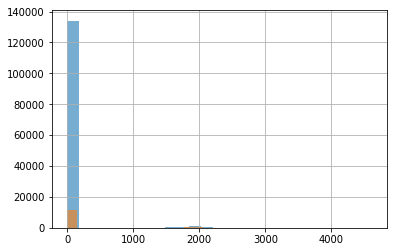

In [86]:
train.loc[train['target'] == -50000, 'capital losses'].hist(bins=25, alpha=0.6);
train.loc[train['target'] == 50000, 'capital losses'].hist(bins=25, alpha=0.6);

In [87]:
train.loc[train['hispanic origin'] == 1,'target'].value_counts()

Series([], Name: target, dtype: int64)

In [88]:
train.loc[(train['capital gains'] > train['capital losses']),'target'].value_counts()

-50000    4963
 50000    2412
Name: target, dtype: int64

In [89]:
train['hispanic origin'].value_counts()

 All other                    130307
 Mexican (Mexicano)             5368
 Mexican-American               4598
 Central or South American      2840
 Puerto Rican                   2180
 Other Spanish                  1809
 Cuban                           953
 NA                              689
 Do not know                     249
 Chicano                         182
Name: hispanic origin, dtype: int64

In [90]:
train['full or part time employment stat'].value_counts()

 Children or Armed Forces              74903
 Full-time schedules                   40579
 Not in labor force                    25534
 PT for non-econ reasons usually FT     3312
 Unemployed full-time                   2311
 PT for econ reasons usually PT         1208
 Unemployed part- time                   804
 PT for econ reasons usually FT          524
Name: full or part time employment stat, dtype: int64

In [93]:
tset = train[feats]
tset.head()

,weeks*wage,ageBinned,2ndGenUS,1stGenUS,is_taxfiler,stockDividends50k,stockDividendsPos,sex,marital stat,education,veterans benefits,full or part time employment stat,target
0,0,10,Yes,No,Yes,No,No,Female,Widowed,High school graduate,2,Not in labor force,-50000
1,0,8,Yes,No,Yes,No,No,Male,Divorced,Some college but no degree,2,Children or Armed Forces,-50000
2,0,2,No,No,Yes,No,No,Female,Never married,10th grade,2,Not in labor force,-50000
5,62400,6,Yes,No,Yes,No,No,Female,Married-civilian spouse present,Some college but no degree,2,Full-time schedules,-50000
6,0,5,Yes,No,Yes,No,No,Male,Married-civilian spouse present,Bachelors degree(BA AB BS),2,Children or Armed Forces,-50000


In [96]:
train.loc[(train['weeks worked in year'] == 0) & (train['wage per hour'] == 0),'target'].value_counts()

-50000    45382
 50000      594
Name: target, dtype: int64